In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import regionmask
import pandas as pd
from geopy.geocoders import Nominatim
from matplotlib.colors import SymLogNorm
from matplotlib.pyplot import cm

import xesmf as xe
#from pykrige.ok import OrdinaryKriging
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import dask
import utils

import geopandas

from numba import jit
import numpy as np
from numba import guvectorize, float64, int64, void

import scipy.signal as signal

In [2]:
#import data from:
### Gallagher, Kevin P. (2021), “China’s Global Energy Finance,” Global Development Policy Center, Boston University.
### Gallagher, Kevin P., Li, Zhongshu, Chen, Xu, Ma, Xinyue (2019), “China’s Global Power Database,” Global Development Policy Center, Boston University.

In [3]:
years = 50
coal_year_range = np.arange(0,41)

In [4]:
## Add time dimension
length_simulation = years*365

time_array = np.arange(0, length_simulation)

In [5]:
CGP_df = pd.read_csv('mod_coal_inputs/BC_limited_country_SEA_GAINS_Springer.csv')

In [6]:
CGP_df.columns = CGP_df.columns.str.replace(' ', '_')

In [7]:
CGP_df = CGP_df.rename(columns = {'YEAR':'Year_of_Commission', 'EMISFACTOR.PLATTS':'CO2_weighted_capacity_1000tonsperMW'})

In [8]:
percent = np.arange(0,100)

In [9]:
print('Emis data prepped and loaded')

Emis data prepped and loaded


Text(0, 0.5, 'Black Carbon Emissions, g/day')

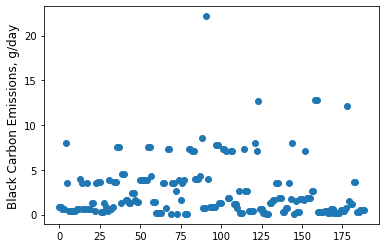

In [26]:
plt.plot(CGP_df['BC_(g/day)'], 'o')
plt.ylabel('Black Carbon Emissions, g/day', fontsize = 12)

# Create Scenario

In [10]:
#######in progress retiring by year after co2#########
def early_retirement_by_CO2_year(year_early, df, CO2_val, time_array, shutdown_years):
    ''' df must have a variable 'Year_of_Commission' describing when the plant was comissioned, and 'BC_(g/day)' for BC emissions in g/day
        year_early is the number of years the plant runs
        min_comission_yr is the earliest year a plant was built and is where our timeline starts
        time_array is the length of time for our simulation
        shutdown_years is the typical lifetime of a coal plant'''
    min_comission_yr = df['Year_of_Commission'].min()
    shutdown_days = shutdown_years*365
    E = np.zeros(len(time_array))
    #print(min_comission_yr)
    #print(shutdown_days)
    test_array = np.where(time_array <= year_early*365, True, False)
    #print('test array len', len(test_array))
    #plt.plot(test_array)
    E += test_array* df.loc[df.CO2_weighted_capacity_1000tonsperMW >= CO2_val]['BC_(g/day)'].sum()
    #fig, ax = plt.subplots()
    #plt.plot(E)
    #plt.title('E')
    #print(E)
    for year_comis in np.arange(min_comission_yr, df['Year_of_Commission'].max()):
        #print(year_comis)
        #print(df.loc[df.Year_of_Commission == year_comis]['BC_(g/day)'].sum())
        #print(np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r))
        test_array = np.where((time_array <= (year_comis-min_comission_yr)*365 + shutdown_days), True, False)
        #plt.plot(test_array)
        #fig, ax = plt.subplots()
        #plt.plot(test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum())
        E += test_array* df.loc[(df.CO2_weighted_capacity_1000tonsperMW < CO2_val) & (df.Year_of_Commission == year_comis)]['BC_(g/day)'].sum()
        #E[year] += (time_array>=0) * df.loc[df.CO2_weighted_capacity_1000tonsperMW < CO2_val]['BC_(g/day)'].sum()
        #plt.plot(E)

    
    return(E)



In [11]:
E_CO2_all_opts = {}
for year in coal_year_range:
    E_CO2_all_opts[year] = {}
    for r in percent:
        E_CO2_all_opts[year][r] = early_retirement_by_CO2_year(year, CGP_df, np.nanpercentile(CGP_df['CO2_weighted_capacity_1000tonsperMW'],r), time_array, 40)
print('Emis profiiles created')

Emis profiiles created


In [13]:
E_CO2_all_opts[20][30]

array([337.42884766, 337.42884766, 337.42884766, ...,  15.50253957,
        15.50253957,  15.50253957])

# Convolve with G

In [14]:
ds_area = xr.open_dataset('/net/fs11/d0/emfreese/GCrundirs/IRF_runs/RRTMG_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4', engine = 'netcdf4')
utils.fix_area_ij_latlon(ds_area);

FileNotFoundError: [Errno 2] No such file or directory: b'/net/fs11/d0/emfreese/GCrundirs/IRF_runs/RRTMG_pulse/SEA/Jan/mod_output/GEOSChem.SpeciesConc.20160101_0000z.nc4'

In [16]:
#import the green's function and set our time step
G = xr.open_dataarray('Outputs/G_all_loc_all_times_BC_total.nc4', chunks = 'auto')
dt = 1 #day

In [17]:
G_lev0 = G.isel(lev = 0).mean(dim = 'run').compute()
G_lev0 = G_lev0.rename({'time':'s'})
print('G prepped')

G prepped


## in dev for looping through emissions inputs

from numba.typed import Dict
from numba.core import types
float_array = types.float64[:]
Dict.empty(
        key_type=types.unicode_type,
        value_type=float_array,
    )

@jit(nopython=True)
def convolve_single_lev_perc_coal(G, E, dt, G_len, G_lat, G_lon, yr_range, percent):
    '''convolves a spatially resolved G that is mean or single level with an emissions scenario of any length'''
    E_len = len(E[0][0])
    C = Dict.empty(
        key_type=types.unicode_type,
        value_type=float64,
    )
    for i, tp in enumerate(np.arange(0,E_len)):
        for y in yr_range.items():
            C[y] = Dict.empty(
        key_type=types.unicode_type,
        value_type=float64,
    )
            for p in percent:
                C[y][p] = np.zeros(((E_len+G_len), G_lat, G_lon))
                C[y][p][i:i+G_len] = C[y][p][i:i+G_len]+ G*E[y][p][i]*dt #C.loc slice or where
    return C

## Complete simple single lev convolution

In [137]:
test_emis = E_CO2_all_opts[0][10]

In [ ]:
from scipy.ndimage import convolve

In [ ]:
import scipy.signal as signal

In [ ]:
pd.date_range(start='1/1/2018', end='1/08/2018')
DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08'],
              dtype='datetime64[ns]', freq='D')

In [118]:
date_arr = pd.date_range(start = '1/1/2020', end = '1/1/2070', freq = 'D')
time_deltas = (date_arr - date_arr[0] + pd.Timedelta(G_lev0.s.max().values + G_lev0.s.diff('s').mean().values))
data = np.zeros((len(G_lev0['lat']),len(G_lev0['lon']),len(time_deltas)))
ds = xr.Dataset(
    data_vars=dict(BC_total=(["lat", "lon", "s"], data),),
    coords=dict(lat=(["lat"], G_lev0['lat'].values),
                lon=(["lon"], G_lev0['lon'].values),
                s=time_deltas))

In [124]:
date_arr = pd.date_range(start = '1/1/2020', end = '1/1/2070', freq = 'D')
time_deltas = (date_arr - date_arr[0] + pd.Timedelta(G_lev0.s.max().values + G_lev0.s.diff('s').mean().values))
data = np.zeros((len(G_lev0['lat']),len(G_lev0['lon']),len(time_deltas)))
ds = xr.Dataset(
    data_vars=dict(BC_total=(["lat", "lon", "s"], data),),
    coords=dict(lat=(["lat"], G_lev0['lat'].values),
                lon=(["lon"], G_lev0['lon'].values),
                s=time_deltas))

ds_new = xr.merge([G_lev0,ds['BC_total']])

In [138]:
%%time
kernel3d = test_emis[..., None, None]
conv3d = lambda x: signal.convolve(x, kernel3d, mode="same")
result3d = xr.apply_ufunc(conv3d, ds_new)

print(result3d)

<xarray.Dataset>
Dimensions:   (s: 18387, lat: 180, lon: 288)
Coordinates:
  * s         (s) timedelta64[ns] 0 days 1 days 2 days ... 18385 days 18386 days
  * lon       (lon) float64 -179.4 -178.1 -176.9 -175.6 ... 176.9 178.1 179.4
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lev       float64 1.0
Data variables:
    BC_total  (s, lat, lon) float64 2.578e-19 2.581e-19 ... -1.712e-33 0.0
CPU times: user 1min 19s, sys: 14.5 s, total: 1min 34s
Wall time: 1min 34s


da = G_lev0
kernel3d = np.ones((3, 3, 1))
conv3d = lambda x: signal.convolve(x, kernel3d, mode="full")
result3d = xr.apply_ufunc(conv3d, da, input_core_dims = [['s']], exclude_dims = set(('s')), output_core_dims = [['lat','lon']])

print(result3d)

da=G_lev0
kernel=np.ones((3,3))
#from scipy.ndimage import convolve
conv1 = lambda x: signal(x, kernel, mode="wrap")
print(xr.apply_ufunc(conv1, da[:,:,:])) # works successfully

@jit(nopython=True)
def convolve_single_lev(G, E, dt, G_len, G_lat, G_lon):
    '''convolves a spatially resolved G that is mean or single level with an emissions scenario of any length'''
    E_len = len(E)
    for i, tp in enumerate(np.arange(0,E_len)):
        C = np.zeros(((E_len+G_len), G_lat, G_lon))
        C[i:i+G_len] = C[i:i+G_len]+ G*E[i]*dt #C.loc slice or where
    return C

@jit(nopython=True)
def convolve_single_lev(G, E, dt, G_len, G_lat, G_lon):

early_many = convolve_single_lev(G_lev0.to_numpy() , test_emis, dt = 1, 
                                 G_len = len(G_lev0.s), G_lat = len(G_lev0.lat), G_lon = len(G_lev0.lon))

@jit(nopython=True)
def convolve_single_lev(G, E, dt, G_len, G_lat, G_lon):
    '''convolves a spatially resolved G that is mean or single level with an emissions scenario of any length'''
    E_len = len(E)
    for i, tp in enumerate(np.arange(0,E_len)):
        C = np.zeros(((E_len+G_len), G_lat, G_lon))
        C[i:i+G_len] = C[i:i+G_len]+ G*E[i]*dt #C.loc slice or where
    return C


early_many = convolve_single_lev(G_lev0.to_numpy() , E_CO2_all_opts[10][10], dt = 1, 
                                 G_len = len(G_lev0.s), G_lat = len(G_lev0.lat), G_lon = len(G_lev0.lon))

In [133]:
def np_to_xr(C, G, E):
    E_len = len(E)
    G_len = len(G.s)
    C = xr.DataArray(
    data = C,
    dims = ['s','lat','lon'],
    coords = dict(
        s = (['s'], np.arange(0, C.shape[0])), #np.arange(0,(E_len+G_len))),
        lat = (['lat'], G.lat.values),
        lon = (['lon'], G.lon.values)
            )
        )
    return(C)

%%time
early_many_sig = signal.convolve(G_lev0.to_numpy() , test_emis[..., None, None], mode = 'full')
test_sig =  np_to_xr(early_many_sig, G_lev0, test_emis)

In [142]:
%%time 
C_out = {}
C_sum = {}
for yr in coal_year_range:
    C_out[yr] = {}
    C_sum[yr] = {}
    for pc in percent:    
        C_out[yr][pc] =  signal.convolve(G_lev0.to_numpy(), E_CO2_all_opts[yr][pc][..., None, None], mode = 'full')
        C_out[yr][pc] = np_to_xr(C_out[yr][pc], G_lev0, E_CO2_all_opts[yr][pc])
        #C_sum[yr][pc] = C_out[yr][pc].sum(dim = 's')

KeyboardInterrupt: 

In [145]:
C_out[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

xr.apply_ufunc(np_to_xr, early_many_sig,  G_lev0, test_emis)

In [ ]:
C_sum.to_csv('Outputs/C_sum.csv')

In [ ]:
C_out.to_netcdf('Outputs/C_out.nc')

#early_many = signal.convolve(G_lev0.to_numpy() , E_CO2_all_opts[10][10][..., None, None], mode = 'full')
later_few = signal.convolve(G_lev0.to_numpy() , E_CO2_all_opts[20][80][..., None, None], mode = 'full')
early_few = signal.convolve(G_lev0.to_numpy() , E_CO2_all_opts[10][80][..., None, None], mode = 'full')
later_many = signal.convolve(G_lev0.to_numpy() , E_CO2_all_opts[20][10][..., None, None], mode = 'full')


%%time

early_many = convolve_single_lev(G_lev0.to_numpy() , E_CO2_all_opts[10][10], dt = 1, 
                                 G_len = len(G_lev0.s), G_lat = len(G_lev0.lat), G_lon = len(G_lev0.lon))

%%time

later_few = convolve_single_lev(G_lev0.to_numpy() , E_CO2_all_opts[20][80], dt = 1, 
                                 G_len = len(G_lev0.s), G_lat = len(G_lev0.lat), G_lon = len(G_lev0.lon))


%%time
early_few = convolve_single_lev(G_lev0.to_numpy() , E_CO2_all_opts[10][80], dt = 1, 
                                 G_len = len(G_lev0.s), G_lat = len(G_lev0.lat), G_lon = len(G_lev0.lon))


%%time
later_many = convolve_single_lev(G_lev0.to_numpy() , E_CO2_all_opts[20][10], dt = 1, 
                                 G_len = len(G_lev0.s), G_lat = len(G_lev0.lat), G_lon = len(G_lev0.lon))


### Convert outputs to xarray

In [23]:
#test = np_to_xr(early_many, G_lev0, test_emis)
test_sig = np_to_xr(early_many_sig, G_lev0, test_emis)

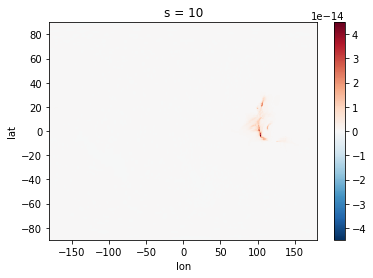

In [24]:
test_sig.isel(s = 10).plot()

G_lev0 = G_lev0.sel(lat = slice(45,150)).sel(lon= slice(-45,50))

KeyboardInterrupt: 

In [23]:
country_mask = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
countries = ['China', 'India','Indonesia','Malaysia','Vietnam','Australia', 'Cambodia','Myanmar', 'Laos','Philippines','Nepal','Bangladesh','Thailand','Bhutan']
print('countries uploaded')

countries uploaded


In [24]:
loc_df = {}
for c in countries:
    loc_df[c] = pd.DataFrame(columns = percent, index = coal_year_range)
    mask = country_mask.mask(C_sum[1][10], lon_name = 'lon', lat_name = 'lat')
    contiguous_mask = ~np.isnan(mask)& (mask == country_mask.map_keys(c))
    for yr in coal_year_range:
        for pc in percent:
            print(yr,pc)
            loc_df[c][pc].loc[yr] = C_sum[yr][pc].where(contiguous_mask).weighted(ds_area['area']).mean().values
            print(c + 'done')
            loc_df[c].to_csv(f'Outputs/{c}_co2_year_shutdown.csv')
            print(c + 'saved')

KeyError: 1